In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split,  GridSearchCV, TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge


In [24]:
sp500 = pd.read_csv('../Data/sp500_main.csv')
macro = pd.read_csv('../Data/macro_data.csv')

In [26]:
yrs_5 = round(sp500.shape[0]/2)
sp500 = sp500[-yrs_5:]
sp500

,Date,AAPL,AMZN,AVGO,COST,GOOG,GOOGL,HD,JPM,LLY,...,META,MSFT,NVDA,ORCL,PG,TSLA,UNH,V,WMT,XOM
1377,2019-06-24,47.804260,95.695000,23.838812,244.098236,55.576309,55.633327,179.916992,92.635323,107.155220,...,192.021851,130.901733,3.794009,52.082222,98.022469,14.909333,229.979050,167.294678,34.155460,58.926094
1378,2019-06-25,47.079662,93.913498,23.609133,243.723160,54.123032,54.182587,179.251633,91.868042,106.904999,...,188.273117,126.768921,3.764683,51.467228,97.490173,14.650667,228.155029,164.821564,33.995792,58.405380
1379,2019-06-26,48.097954,94.891502,24.030066,241.938843,53.796707,53.820892,180.722427,92.481865,103.179611,...,187.096680,127.243965,3.958036,52.008804,95.753639,14.618000,224.294998,164.609924,33.823860,58.658096
1380,2019-06-27,48.083515,95.213997,24.394653,243.009399,53.607880,53.637062,181.247742,92.788757,103.300102,...,188.931152,127.452988,4.056702,52.109760,95.797272,14.856000,226.938934,164.773438,33.805428,58.060780
1381,2019-06-28,47.645382,94.681503,24.578226,241.801620,53.852005,53.944447,182.079514,95.312225,102.669930,...,192.420639,127.272423,4.081554,52.293343,95.683815,14.897333,224.792496,167.006012,33.925186,58.681042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2750,2024-12-05,243.039993,220.550003,170.470001,982.260010,174.112473,172.442368,426.540009,245.479996,825.619995,...,608.929993,442.619995,145.059998,186.240005,176.029999,369.489990,576.757812,309.079987,95.300003,114.779999
2751,2024-12-06,242.839996,227.029999,179.529999,992.609985,176.290009,174.510010,431.369995,247.360001,826.710022,...,623.770020,443.570007,142.440002,191.690002,173.820007,389.220001,547.519958,311.010010,95.699997,113.570000
2752,2024-12-09,246.750000,226.089996,178.940002,987.859985,177.100006,175.369995,429.179993,243.809998,803.580017,...,613.570007,446.019989,138.809998,190.449997,170.789993,389.790009,560.619995,308.299988,93.830002,112.900002
2753,2024-12-10,247.770004,225.039993,171.809998,993.400024,186.529999,185.169998,422.589996,242.860001,799.580017,...,619.320007,443.329987,135.070007,177.740005,172.279999,400.989990,565.190002,312.380005,94.550003,112.669998


In [28]:
macro= macro.set_index('Date')
sp500 = sp500.set_index('Date')

In [30]:
# Loop through each unique ticker (stock) in the DataFrame
indicator = pd.DataFrame()
for ticker in sp500.columns:
    # Calculate SMAs 
    indicator[f'{ticker}_SMA3'] = sp500[ticker].rolling(window=3).mean()
    indicator[f'{ticker}_SMA20'] = sp500[ticker].rolling(window=20).mean()
    indicator[f'{ticker}_SMA50'] = sp500[ticker].rolling(window=50).mean()
    indicator[f'{ticker}_SMA100'] = sp500[ticker].rolling(window=100).mean()
    indicator[f'{ticker}_SMA200'] = sp500[ticker].rolling(window=200).mean()
    
    # Calculate EMA
    indicator[f'{ticker}_EMA3'] = sp500[ticker].ewm(span=3, adjust=False).mean()
    indicator[f'{ticker}_EMA12'] = sp500[ticker].ewm(span=12, adjust=False).mean()
    indicator[f'{ticker}_EMA26'] = sp500[ticker].ewm(span=26, adjust=False).mean()
    
    # Calculate MACD
    indicator[f'{ticker}_MACD'] = indicator[f'{ticker}_EMA12'] - indicator[f'{ticker}_EMA26']
    
    # Calculate Signal line (9-day EMA of the MACD)
    indicator[f'{ticker}_signal'] = indicator[f'{ticker}_MACD'].ewm(span=9, adjust=False).mean()
    
    # Concatenate each ticker's results into the final indicator DataFrame
    indicator = pd.concat([indicator, sp500], axis=1)

In [31]:
indicator = indicator.dropna()

In [34]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Merge all the files that have X-variable (features)
features_df = pd.merge(macro, indicator, on='Date', how='outer')
features_df = features_df.fillna(method='ffill').dropna()

In [36]:
# drop the same column names
features_df = features_df.loc[:, ~features_df.columns.duplicated()]

In [38]:
# Make the rows number the same with target and features files
# set the index to the format Datetime
sp500.index = pd.to_datetime(sp500.index)
features_df.index = pd.to_datetime(features_df.index)

# Align the two DataFrames by finding the intersection of their indices
common_index = sp500.index.intersection(features_df.index)

# Reindex both DataFrames to the common index
sp500 = sp500.loc[common_index]
features_df = features_df.loc[common_index]

In [40]:
features_df.shape, sp500.shape

((1179, 224), (1179, 20))

In [42]:
# define X and y
X = features_df 
y = sp500 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Training set shape for AAPL: X_train: (819, 224), y_train: (819,)
Testing set shape for AAPL: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for AAPL: {'alpha': 0.01}
Performance for AAPL - RMSE: 0.02060648344732173


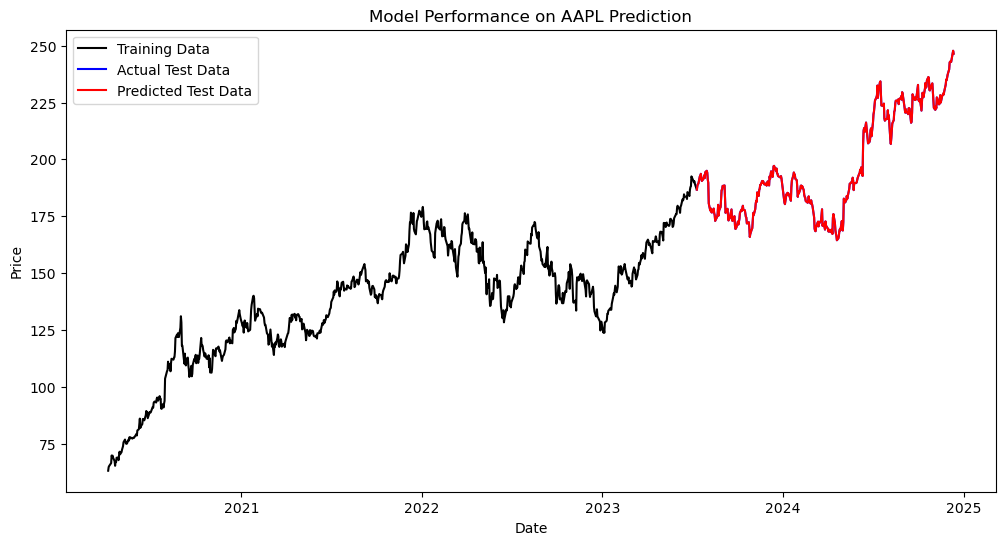

Training set shape for AMZN: X_train: (819, 224), y_train: (819,)
Testing set shape for AMZN: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for AMZN: {'alpha': 0.01}
Performance for AMZN - RMSE: 0.005891647593521332


<Figure size 640x480 with 0 Axes>

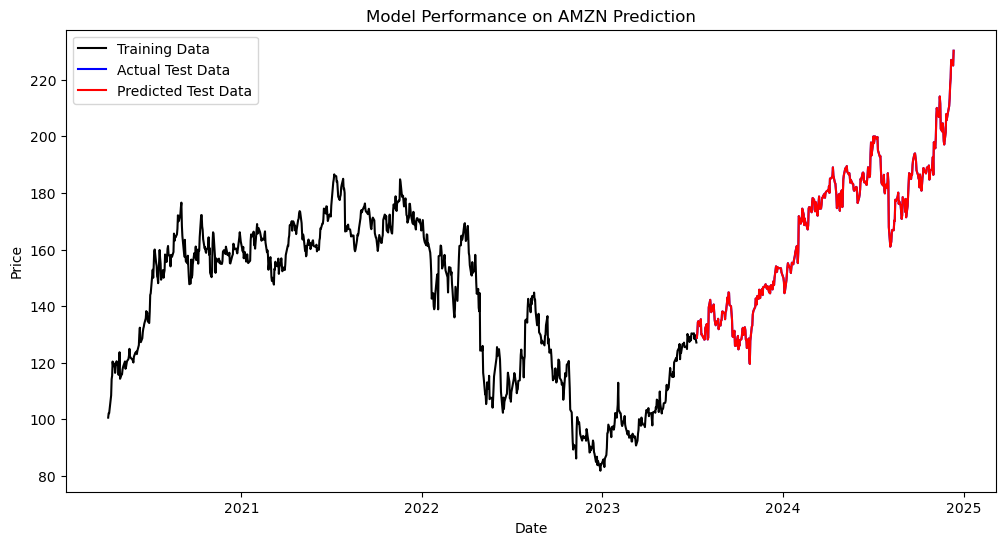

Training set shape for AVGO: X_train: (819, 224), y_train: (819,)
Testing set shape for AVGO: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for AVGO: {'alpha': 0.01}
Performance for AVGO - RMSE: 0.05248731773353554


<Figure size 640x480 with 0 Axes>

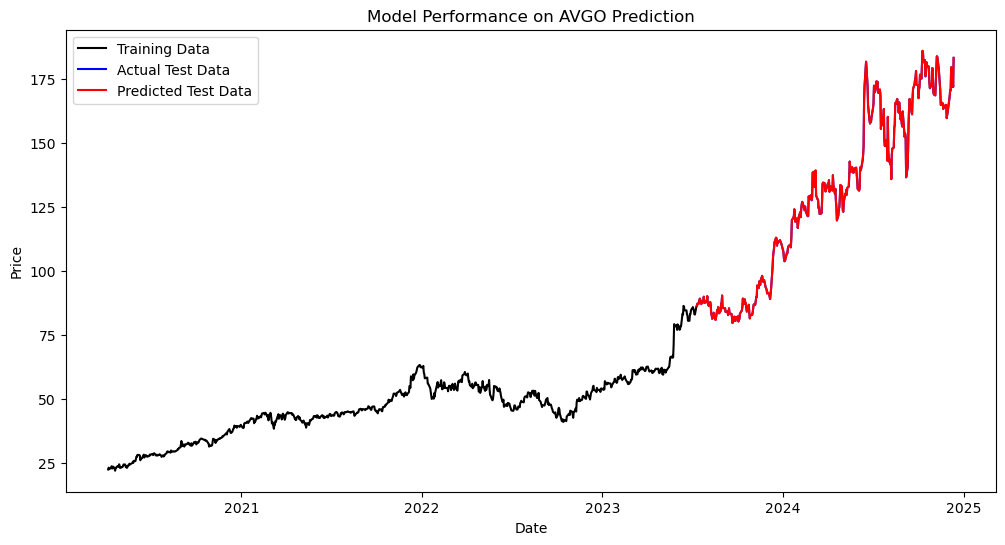

Training set shape for COST: X_train: (819, 224), y_train: (819,)
Testing set shape for COST: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for COST: {'alpha': 0.01}
Performance for COST - RMSE: 0.01022171138563518


<Figure size 640x480 with 0 Axes>

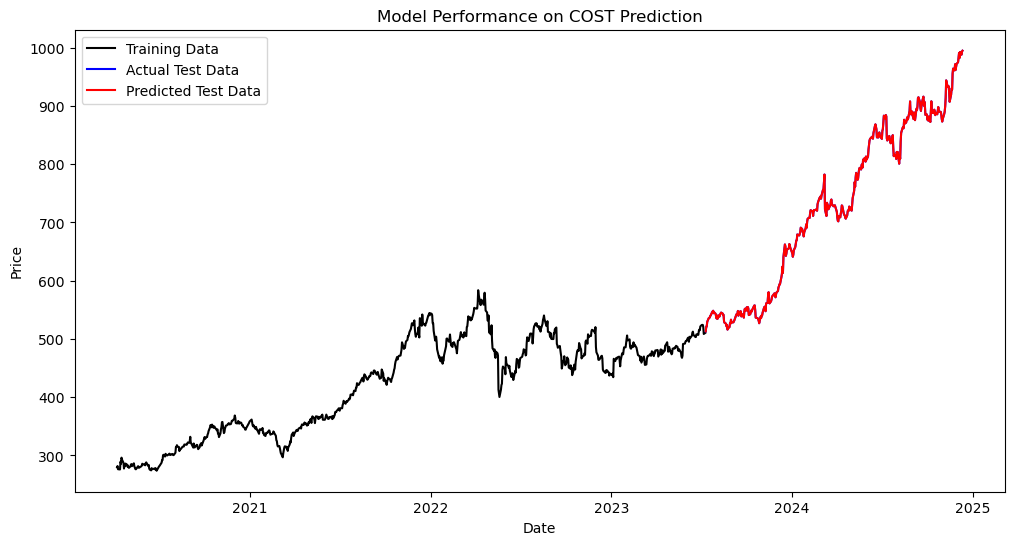

Training set shape for GOOG: X_train: (819, 224), y_train: (819,)
Testing set shape for GOOG: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for GOOG: {'alpha': 0.01}
Performance for GOOG - RMSE: 0.06373564973646942


<Figure size 640x480 with 0 Axes>

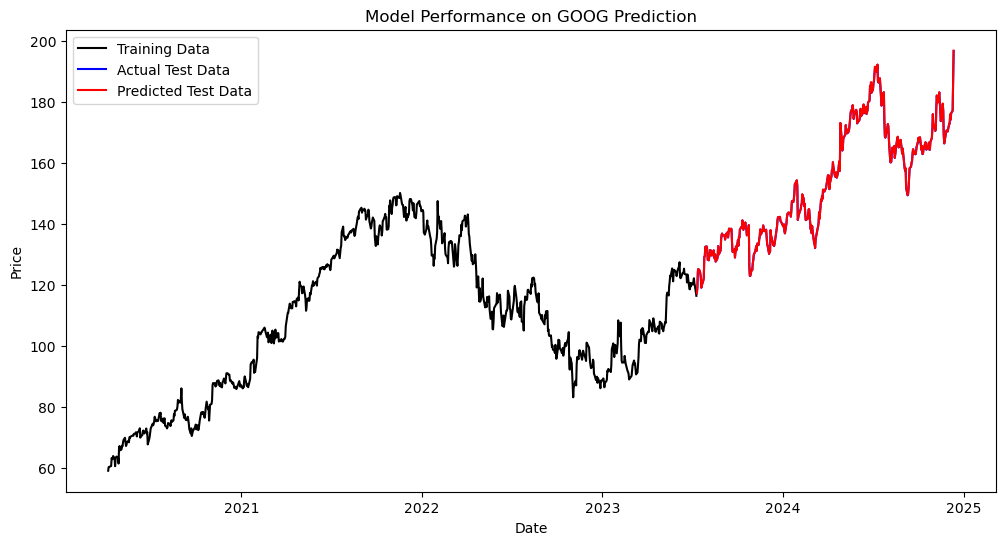

Training set shape for GOOGL: X_train: (819, 224), y_train: (819,)
Testing set shape for GOOGL: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for GOOGL: {'alpha': 0.01}
Performance for GOOGL - RMSE: 0.07119296337230574


<Figure size 640x480 with 0 Axes>

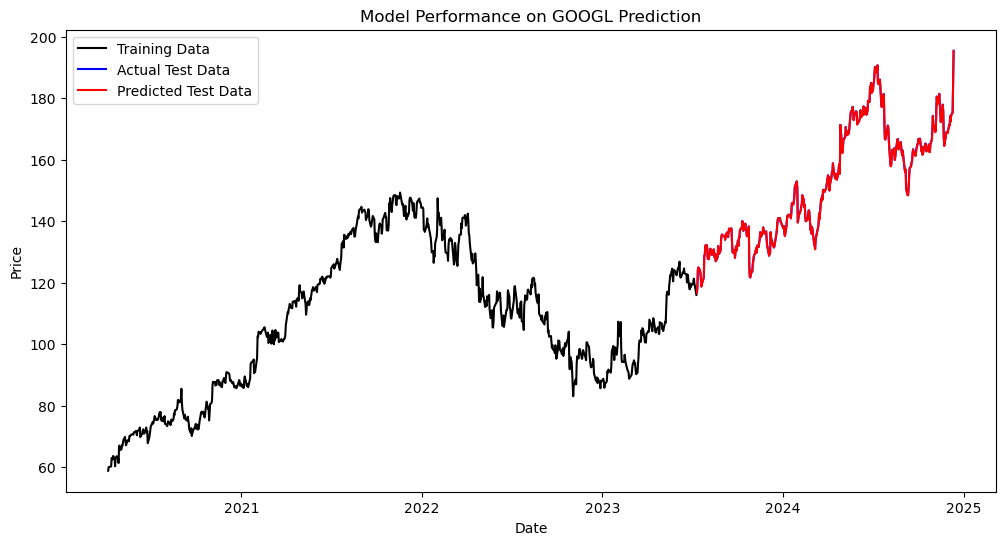

Training set shape for HD: X_train: (819, 224), y_train: (819,)
Testing set shape for HD: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for HD: {'alpha': 0.01}
Performance for HD - RMSE: 0.007487282374016608


<Figure size 640x480 with 0 Axes>

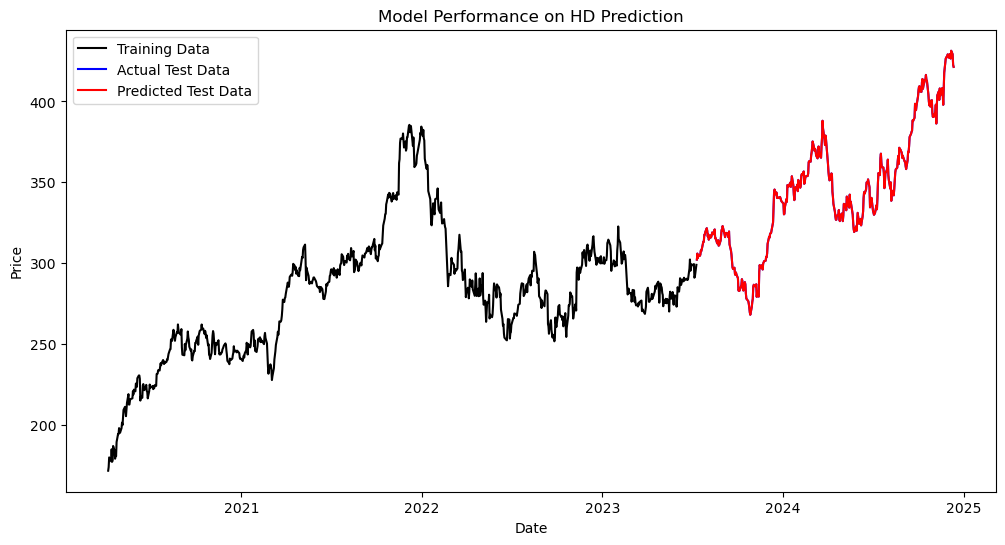

Training set shape for JPM: X_train: (819, 224), y_train: (819,)
Testing set shape for JPM: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for JPM: {'alpha': 0.01}
Performance for JPM - RMSE: 0.02147450678798423


<Figure size 640x480 with 0 Axes>

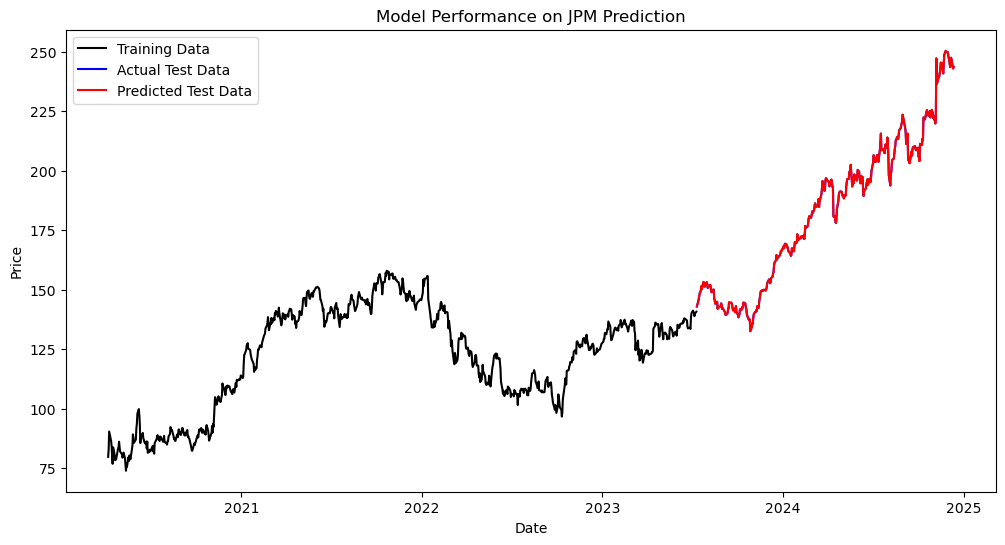

Training set shape for LLY: X_train: (819, 224), y_train: (819,)
Testing set shape for LLY: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for LLY: {'alpha': 0.01}
Performance for LLY - RMSE: 0.007812868077524028


<Figure size 640x480 with 0 Axes>

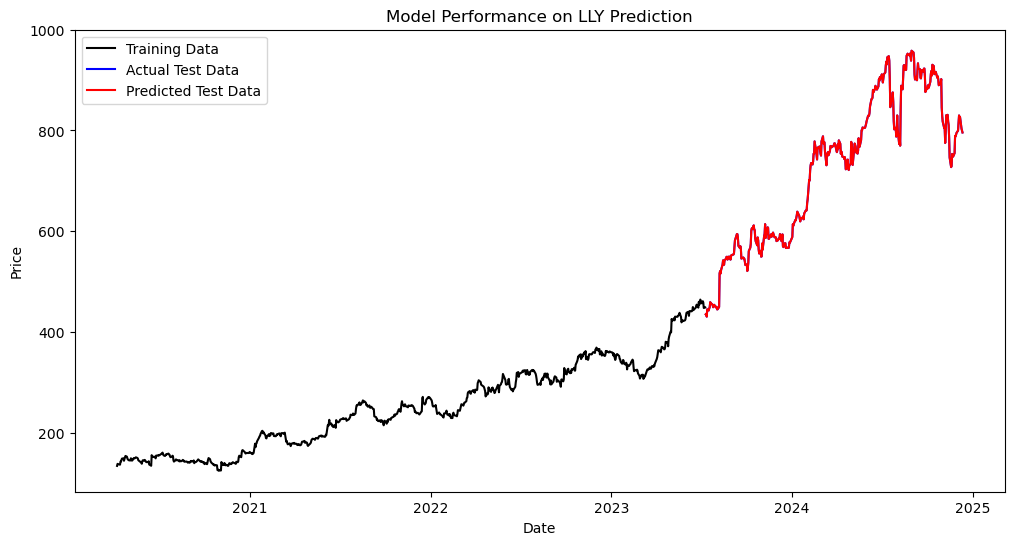

Training set shape for MA: X_train: (819, 224), y_train: (819,)
Testing set shape for MA: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for MA: {'alpha': 0.01}
Performance for MA - RMSE: 0.0076420560463568935


<Figure size 640x480 with 0 Axes>

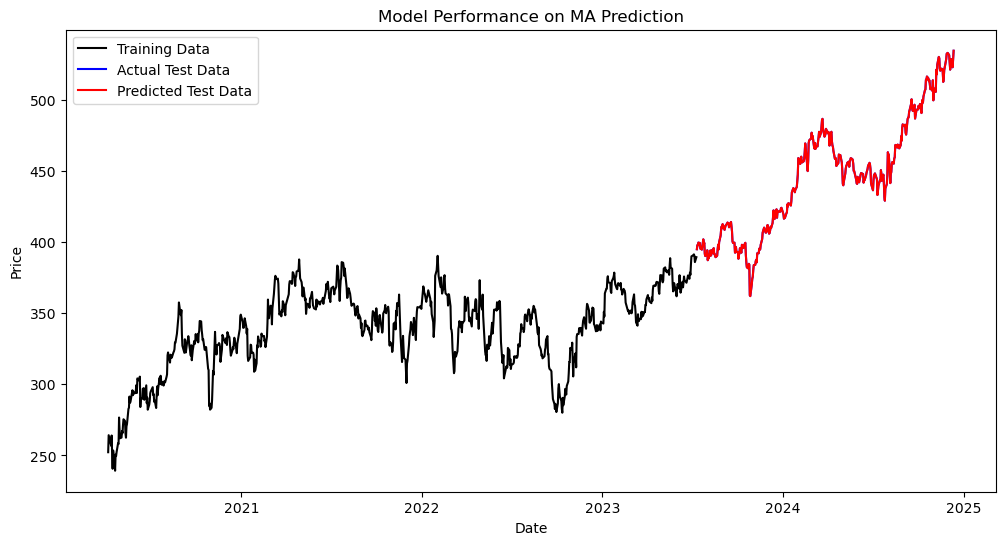

Training set shape for META: X_train: (819, 224), y_train: (819,)
Testing set shape for META: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for META: {'alpha': 0.01}
Performance for META - RMSE: 0.002574933301867814


<Figure size 640x480 with 0 Axes>

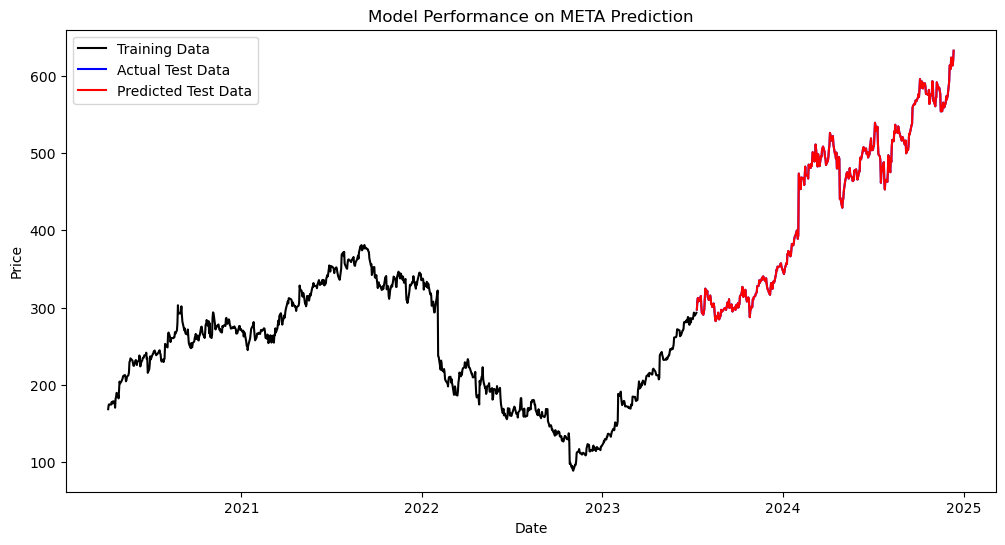

Training set shape for MSFT: X_train: (819, 224), y_train: (819,)
Testing set shape for MSFT: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for MSFT: {'alpha': 0.01}
Performance for MSFT - RMSE: 0.009240401010588402


<Figure size 640x480 with 0 Axes>

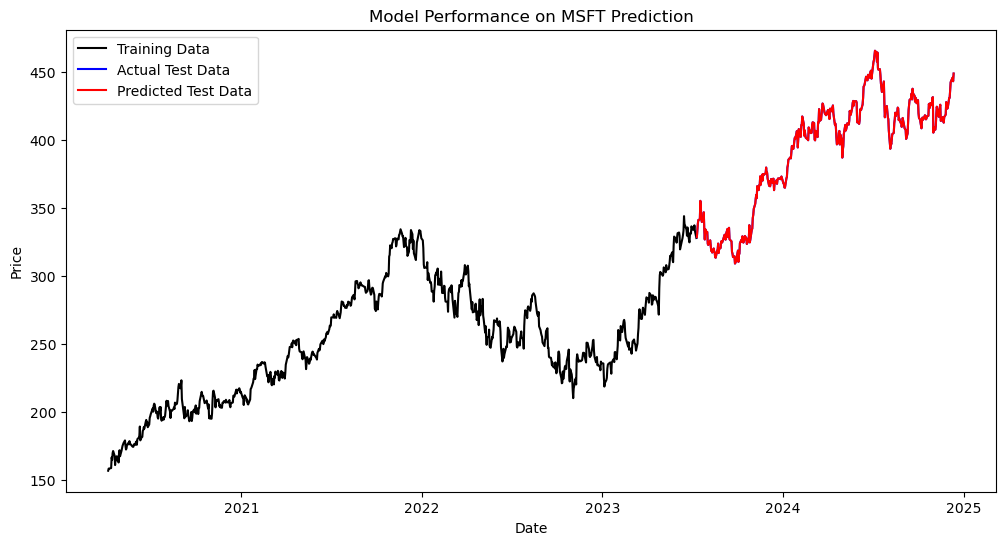

Training set shape for NVDA: X_train: (819, 224), y_train: (819,)
Testing set shape for NVDA: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for NVDA: {'alpha': 0.1}
Performance for NVDA - RMSE: 0.2596373425956404


<Figure size 640x480 with 0 Axes>

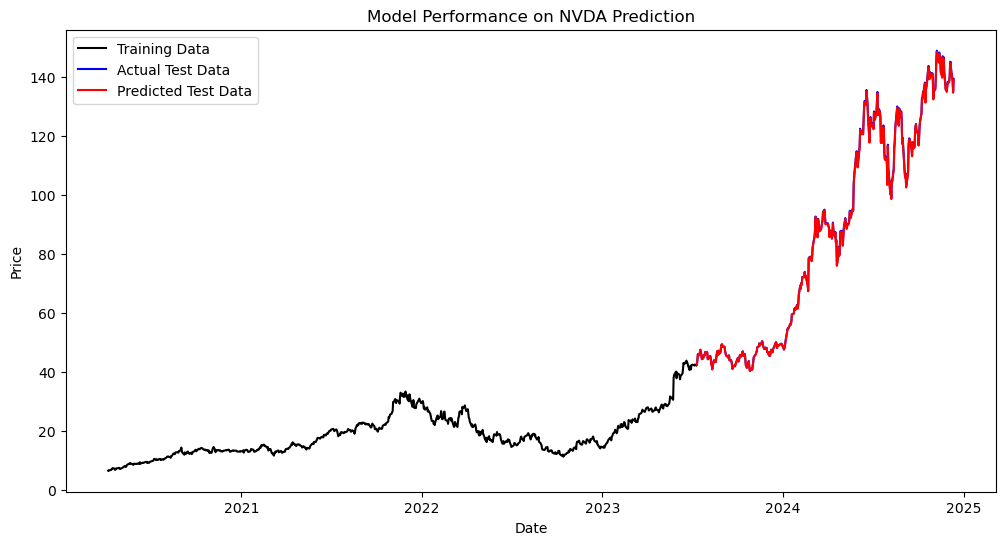

Training set shape for ORCL: X_train: (819, 224), y_train: (819,)
Testing set shape for ORCL: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for ORCL: {'alpha': 0.01}
Performance for ORCL - RMSE: 0.035912417319206226


<Figure size 640x480 with 0 Axes>

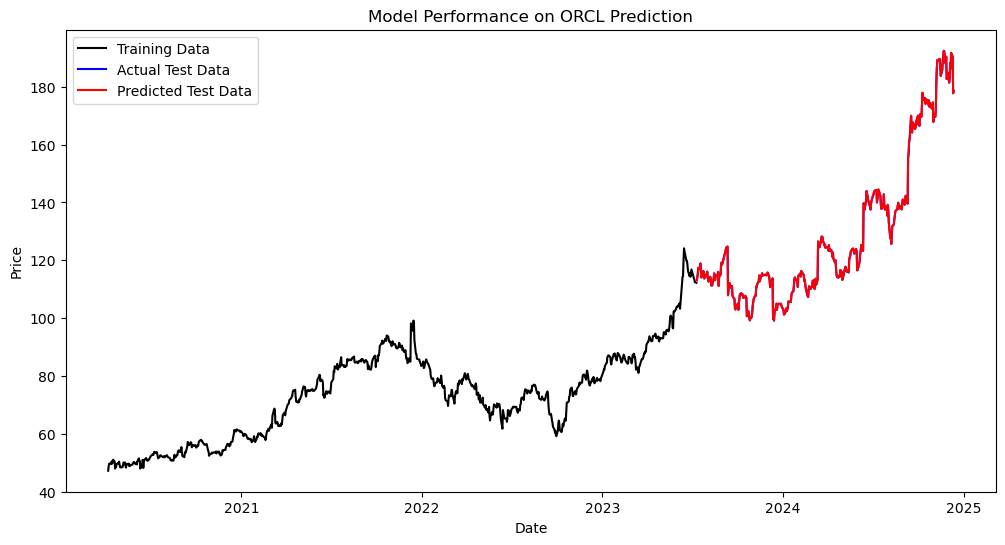

Training set shape for PG: X_train: (819, 224), y_train: (819,)
Testing set shape for PG: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for PG: {'alpha': 0.01}
Performance for PG - RMSE: 0.005734668539755723


<Figure size 640x480 with 0 Axes>

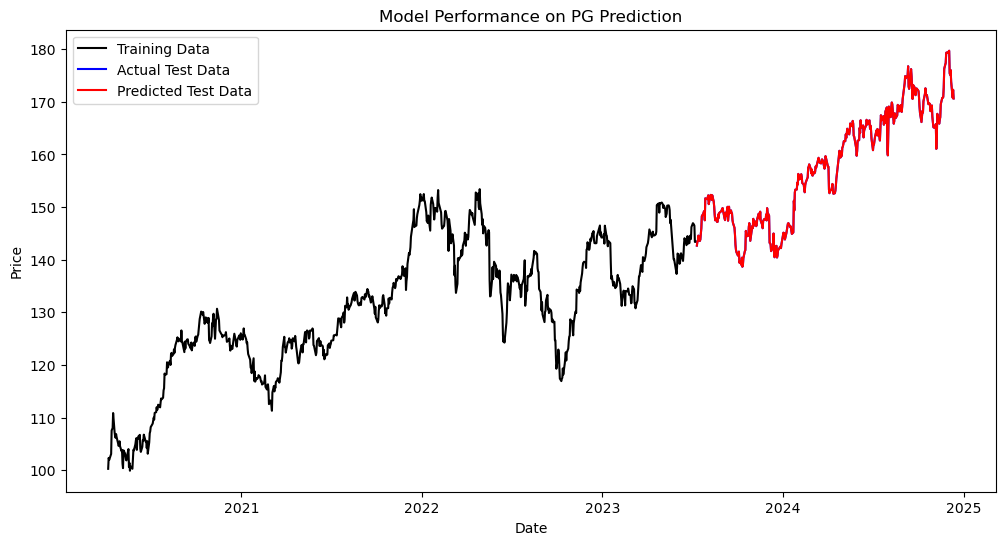

Training set shape for TSLA: X_train: (819, 224), y_train: (819,)
Testing set shape for TSLA: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for TSLA: {'alpha': 0.01}
Performance for TSLA - RMSE: 0.004967787299163673


<Figure size 640x480 with 0 Axes>

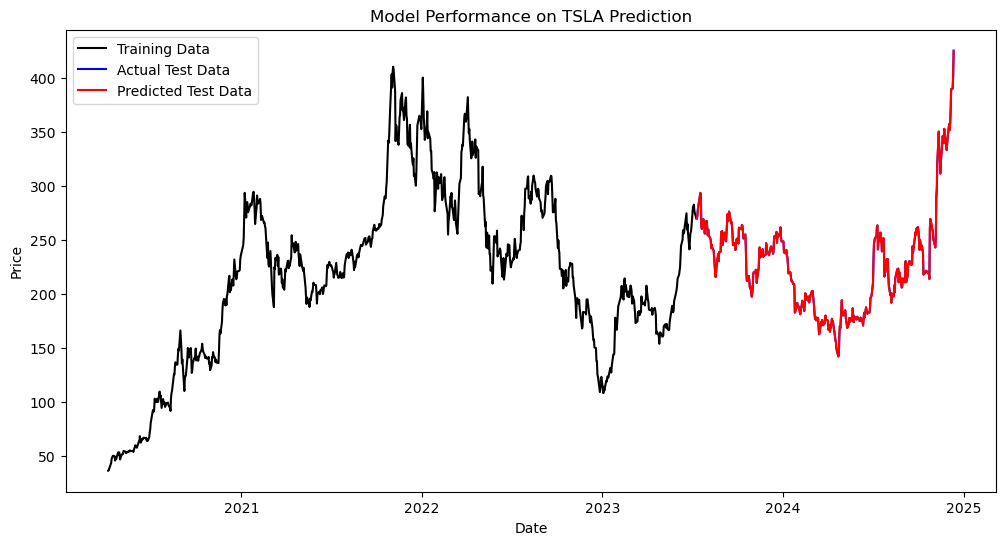

Training set shape for UNH: X_train: (819, 224), y_train: (819,)
Testing set shape for UNH: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for UNH: {'alpha': 0.01}
Performance for UNH - RMSE: 0.0011497600009917801


<Figure size 640x480 with 0 Axes>

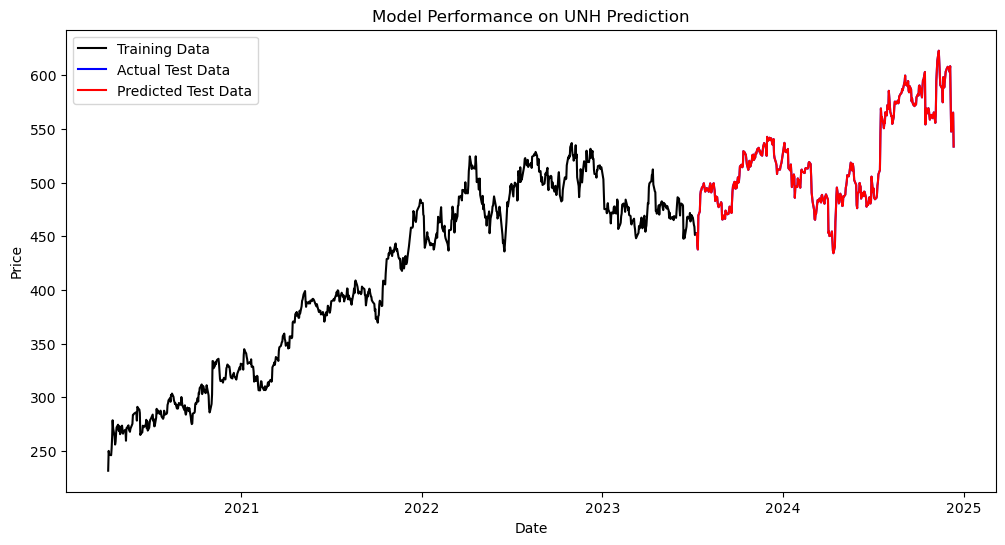

Training set shape for V: X_train: (819, 224), y_train: (819,)
Testing set shape for V: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for V: {'alpha': 0.01}
Performance for V - RMSE: 0.006214331556876667


<Figure size 640x480 with 0 Axes>

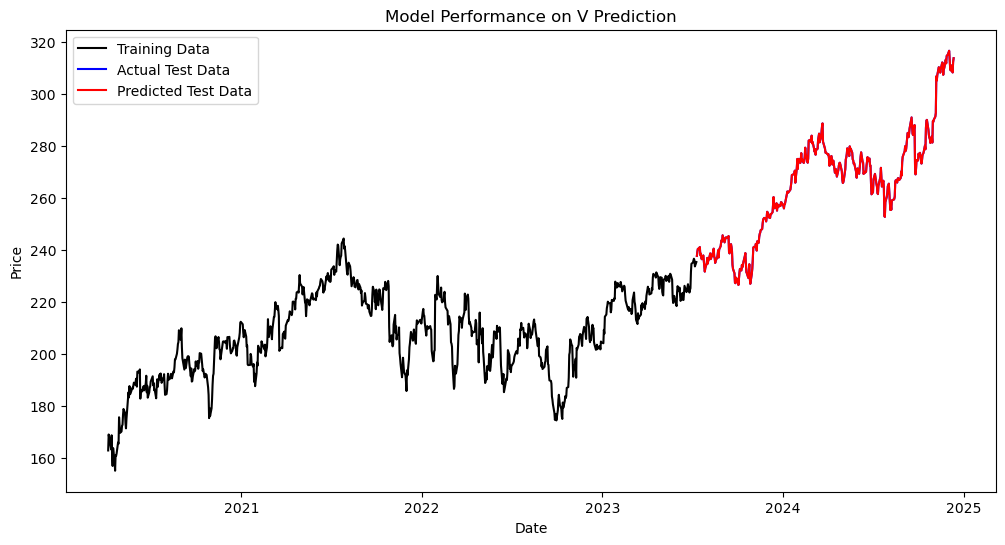

Training set shape for WMT: X_train: (819, 224), y_train: (819,)
Testing set shape for WMT: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for WMT: {'alpha': 0.01}
Performance for WMT - RMSE: 0.03623275001119848


<Figure size 640x480 with 0 Axes>

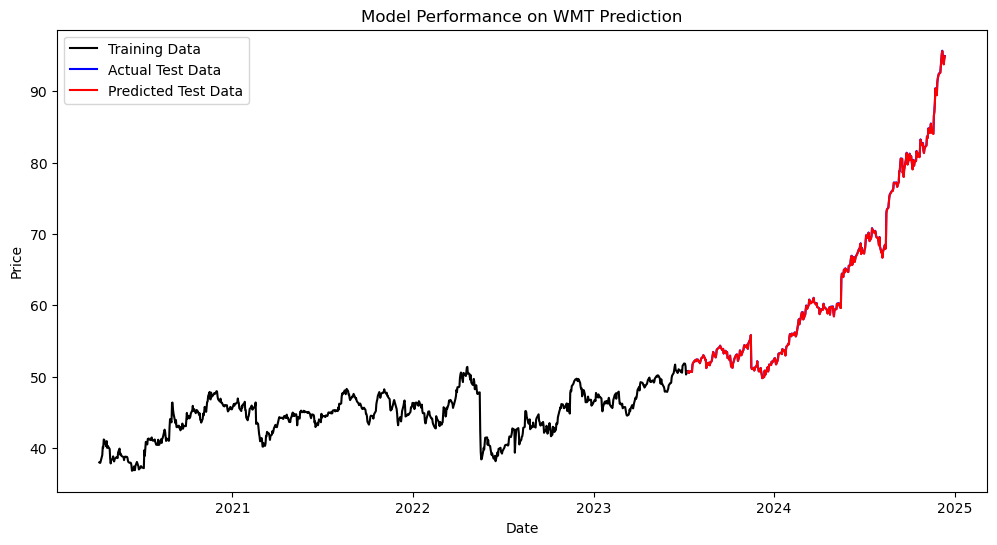

Training set shape for XOM: X_train: (819, 224), y_train: (819,)
Testing set shape for XOM: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for XOM: {'alpha': 0.01}
Performance for XOM - RMSE: 0.013136558058314764


<Figure size 640x480 with 0 Axes>

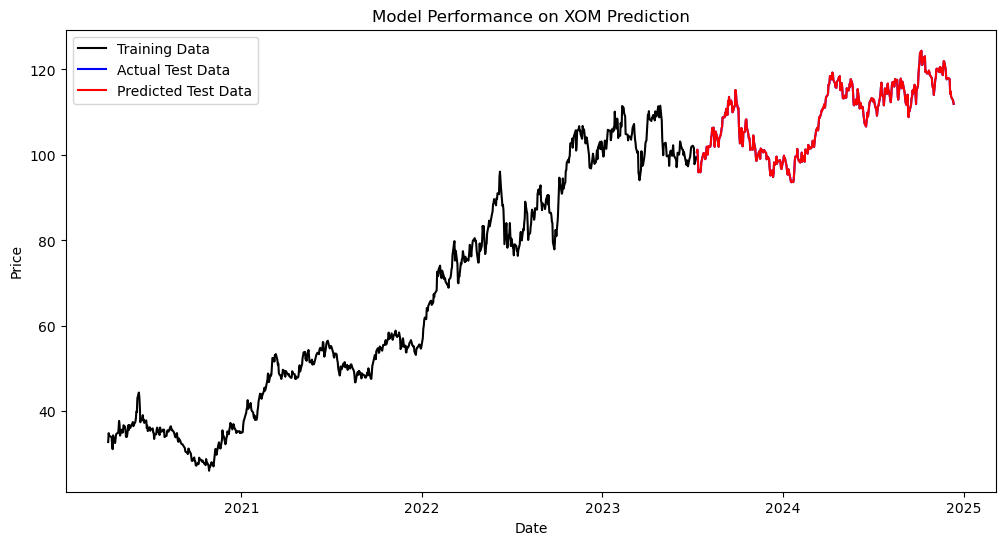

<Figure size 640x480 with 0 Axes>

In [44]:
# Initialize dictionaries to store results
results = {}

# Define the hyperparameter grid for GridSearchCV (alpha for regularization strength)
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]  # Regularization strength
}

# Fixed test size for the last 360 rows
test_size = 360

# Time Series Split for cross-validation (preserves order)
tscv = TimeSeriesSplit(n_splits=3)

# Loop through each stock in the sp500 DataFrame
for stock in sp500.columns:
    
    # Prepare the target (stock price) for each stock
    y_stock = sp500[stock]  # Stock price for this particular stock
    
    # Define training and testing sets
    X_train = features_df.iloc[:-test_size, :]
    X_test = features_df.iloc[-test_size:, :]
    y_train = y_stock.iloc[:-test_size]
    y_test = y_stock.iloc[-test_size:]
    
    # Print dataset shapes
    print(f"Training set shape for {stock}: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing set shape for {stock}: X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    # Initialize Ridge Regression model
    ridge_reg = Ridge()

    # Perform Grid Search with TimeSeriesSplit cross-validation
    grid_search = GridSearchCV(estimator=ridge_reg, 
                               param_grid=param_grid, 
                               cv=tscv, 
                               scoring='neg_mean_squared_error', 
                               verbose=1)
    
    # Fit the GridSearchCV model to the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best hyperparameters from the grid search
    best_params = grid_search.best_params_
    print(f"Best Hyperparameters for {stock}: {best_params}")
    
    # Use the best estimator found by GridSearchCV to make predictions
    best_model = grid_search.best_estimator_
    
    # Make predictions on the test data
    y_pred = best_model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    print(f'Performance for {stock} - RMSE: {rmse}')
    
    # Store the results (model, predictions, evaluation metrics)
    results[stock] = {
        'model': best_model, 
        'predictions': y_pred,
        'mse': mse,
        'rmse': rmse
    }
    
    # Combine training and testing actual prices for visualization
    plt.figure(figsize=(12, 6))
    
    # Plot training data (black)
    plt.plot(y_stock.index[:-test_size], y_stock.values[:-test_size], color='black', label='Training Data')
    
    # Plot actual test data (blue)
    plt.plot(y_stock.index[-test_size:], y_stock.values[-test_size:], color='blue', label='Actual Test Data')
    
    # Overlay the predicted prices for the test set (red)
    plt.plot(y_test.index, y_pred, color='red', label='Predicted Test Data')
    
    # Add title and labels
    plt.title(f'Model Performance on {stock} Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    
    # Display the plot
    plt.show()

    # Save the plot
    plt.savefig(f'../images/{stock}_ridge_prediction.png', format='png')
